In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"

raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)
from prophet import Prophet

# 选择一天的数据
print(raw_data.index) 
one_data = raw_data["2024-01-12 00:00:00":"2024-01-12 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]

test_data.columns = ["y"]
test_data["ds"] = test_data.index

# 转换列名
test_data.columns = ["y"]
test_data.loc[:, "ds"] = test_data.index
n = len(test_data)

train = test_data.iloc[: int(n * 0.8), :]
test = test_data.iloc[int(n * 0.8) :, :]

print(test_data.head())

m = Prophet()
m.fit(train)
fcst = m.predict(test)
fig = m.plot(fcst)


Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')


## old version of Prophet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_country_holidays(country_name='CN')

data = raw_data[[r"'VA.NOX($mg/m^{3}$)'"]]
# model.fit(data)




## New version of Prophet

In [19]:
from prophet import Prophet

# 选择一天的数据
print(raw_data.index) 
one_data = raw_data["2024-01-12 00:00:00":"2024-01-12 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]

test_data.columns = ["y"]
test_data["ds"] = test_data.index

# 转换列名
test_data.columns = ["y"]
test_data.loc[:, "ds"] = test_data.index
n = len(test_data)

train = test_data.iloc[: int(n * 0.8), :]
test = test_data.iloc[int(n * 0.8) :, :]

print(train.head())
print(test.head())


# m = Prophet()
# m.fit(train)
# fcst = m.predict(test)
# fig = m.plot(fcst)

DatetimeIndex(['2023-12-11 18:48:28', '2023-12-11 18:48:32',
               '2023-12-11 18:48:36', '2023-12-11 18:48:40',
               '2023-12-11 18:48:44', '2023-12-11 18:48:48',
               '2023-12-11 18:48:52', '2023-12-11 18:48:56',
               '2023-12-11 18:49:00', '2023-12-11 18:49:04',
               ...
               '2024-01-12 17:09:32', '2024-01-12 17:09:36',
               '2024-01-12 17:09:40', '2024-01-12 17:09:44',
               '2024-01-12 17:09:48', '2024-01-12 17:09:52',
               '2024-01-12 17:09:56', '2024-01-12 17:10:00',
               '2024-01-12 17:10:04', '2024-01-12 17:10:08'],
              dtype='datetime64[ns]', name='时间', length=690336, freq=None)
Unexpected exception formatting exception. Falling back to standard exception


C:\Users\glx\AppData\Local\Temp\ipykernel_22148\498346427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["ds"] = test_data.index
Traceback (most recent call last):
  File "c:\Users\glx\anaconda3\envs\ft\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\glx\AppData\Local\Temp\ipykernel_22148\498346427.py", line 13, in <module>
    test_data.columns = ["y"]
  File "c:\Users\glx\anaconda3\envs\ft\lib\site-packages\pandas\core\generic.py", line 6307, in __setattr__
  File "properties.pyx", line 69, in pandas._libs.properties.AxisProperty.__set__
  File "c:\Users\glx\anaconda3\envs\ft\lib\site-packages\pandas\core\generic.py", line 813, in 

C:\Users\glx\AppData\Local\Temp\ipykernel_22148\2897151693.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, "ds"] = test_data.index
20:29:21 - cmdstanpy - INFO - Chain [1] start processing


Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')
DatetimeIndex(['2023-12-11 18:48:28', '2023-12-11 18:48:32',
               '2023-12-11 18:48:36', '2023-12-11 18:48:40',
               '2023-12-11 18:48:44', '2023-12-11 18:48:48',
               '2023-12-11 18:48:52', '2023-12-11 18:48:56',
       

20:29:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\glx\anaconda3\envs\ft\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\glx\anaconda3\envs\ft\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  label='Observed data points')


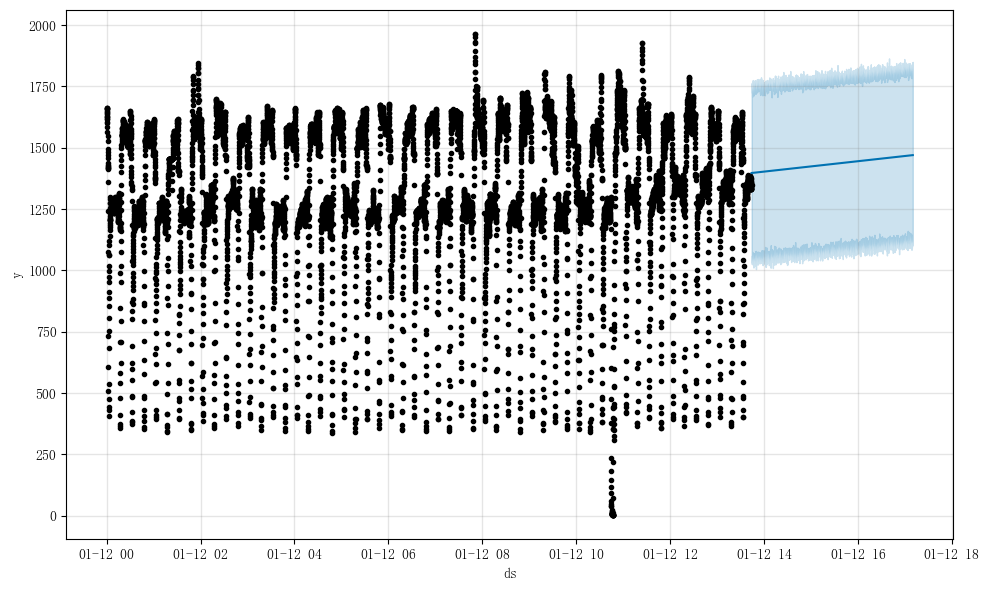

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"

raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)
from prophet import Prophet

# 选择一天的数据
print(raw_data.index)
one_data = raw_data["2024-01-12 00:00:00":"2024-01-12 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]

# 转换列名
test_data.columns = ["y"]
test_data.loc[:, "ds"] = test_data.index
n = len(test_data)

train = test_data.iloc[: int(n * 0.8), :]
test = test_data.iloc[int(n * 0.8) :, :]

print(test_data.head())

m = Prophet()
m.fit(train)
fcst = m.predict(test)
fig = m.plot(fcst)



==========================================smooth freq done==========================================


<Axes: xlabel='时间'>

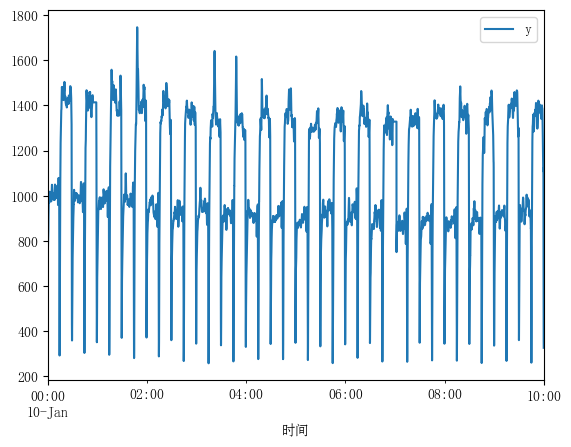

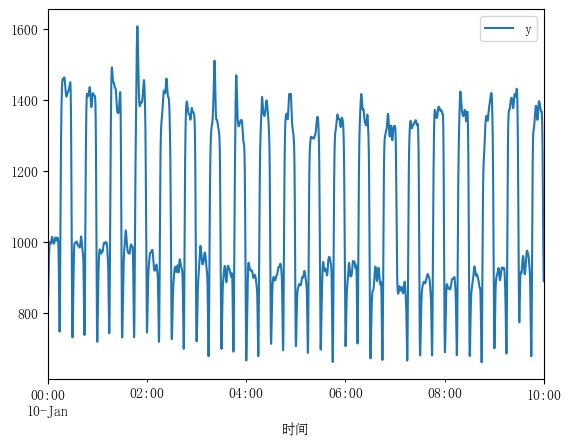

In [9]:
# 滤波平滑:
from scipy.ndimage import gaussian_filter
from copy import deepcopy


def do_smooth(data, sigma=1):
    """do data smooth and save figure in folder "smooth" """
    smoothed_data = deepcopy(data)
    data_smooth = gaussian_filter(data["y"], sigma)
    smoothed_data.loc[:,"y"] = data_smooth

    print("smooth freq done".center(100, "="))
    return smoothed_data

test_data.plot()
smooth_data = do_smooth(test_data, sigma=10)
smooth_data.plot()



In [12]:
# 训练集和测试集
new_time_index = pd.date_range("2021-01-01 00:00:00", freq="h", periods=len(smooth_data))
smooth_data.index = new_time_index
smooth_data.loc[:, "ds"] = new_time_index

n = len(new_time_index)

# 0.8作为训练集，0.2作为测试集
train_scale = 0.8
train = smooth_data[:int(n*train_scale)]
test = smooth_data[int(n*train_scale):]

# train_checkpoint = 75
# train = smooth_data[:-train_checkpoint]
# test = smooth_data[-train_checkpoint:]


# prophet模型
m = Prophet()
m.fit(train)


17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing


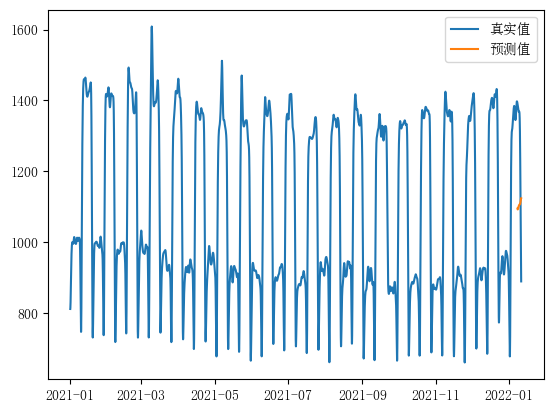

In [11]:
from prophet.plot import plot_plotly, plot_components_plotly

predict = m.predict(test)
predict.index = test.index
# m.plot_components(m.predict(test_data))
# fig2 = m.plot(predict)



# draw the predict and real data 
# plt.figure(figsize=(16, 9))
plt.plot(smooth_data.loc[:,"y"], label="真实值")
plt.plot(predict["yhat"], label="预测值")
plt.legend()
